In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
from collections import Counter
import random

#entropy
from scipy.stats import entropy

#DTW
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import dtaidistance
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering

#plot
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#https://en.wikipedia.org/wiki/Sample_entropy
def sampen(L, r=2, m=2):
    '''Usually m=2 and r=0.2*std'''
    N = len(L)
    B = 0.0
    A = 0.0
    
    # Split time series and save all templates of length m
    xmi = np.array([L[i:i+m] for i in range(N-m)])
    xmj = np.array([L[i:i+m] for i in range(N-m+1)])
       
    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii-xmj).max(axis=1) <= r)-1 for xmii in xmi])
            
    # Similar for computing A
    m += 1
    xm = np.array([L[i:i+m] for i in range(N-m+1)])
        
    A = np.sum([np.sum(np.abs(xmi-xm).max(axis=1) <= r)-1 for xmi in xm])
    
    # Return SampEn
    return -np.log(A/B)

In [3]:
sampen([])

<ipython-input-2-1b92a34f6876>:22: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A/B)


nan

In [4]:
#not linked to the order, only the distribution (proba of a certain zone)
def Entropy(labels):
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts)
#small test
#print(Entropy([1,1,1,1,1,1,1,1,0,2,3,4,5,6,7,8,9,9,9,9]), 
#      Entropy([0,2,3,4,5,6,7,8,9,9,9,9,1,1,1,1,1,1,1,1]),
#      Entropy([1,1,1,1,1,1,1,1]), 
#      Entropy([1,0,1,1,1,1,1,1,0]), 
#      Entropy([0,1,1,1,1,1,1,0,1]), 
#      Entropy([1,1,0,0,1,1,1,1,1]),
#      Entropy(['1','1','8','9','9'])) #categorical values oke
#1.8866967846580784 1.8866967846580784 0.0 0.5297061990576545 0.5297061990576545 0.5297061990576545

In [5]:
#function computing the Dynamic Time Warping distance between each one-to-one hens from the same pen and output as a matrix 
#dico: is a dictionary of time series, possibly given by the previous function
def time_series_DTW(dico):
    
    #L: list to say which time series correspond to which row of matrix
    L = {i:list(dico.keys())[i] for i in range(0,len(dico))}
    M = np.zeros(shape=(len(dico),len(dico)))
    
    #compute distance for each pairs of individual
    for i in range(0,len(dico)):
        #for j in range(i+1,len(dico)): #not necessarily symmetric, but slower in taht case!
        for j in range(0,len(dico)): 
            dist, path = fastdtw(dico[L[i]], dico[L[j]], dist=euclidean)
            M[i,j] = dist
            #M[j,i] = dist
            
    return M,L

### simulate time series & DTW

3.3166247903554


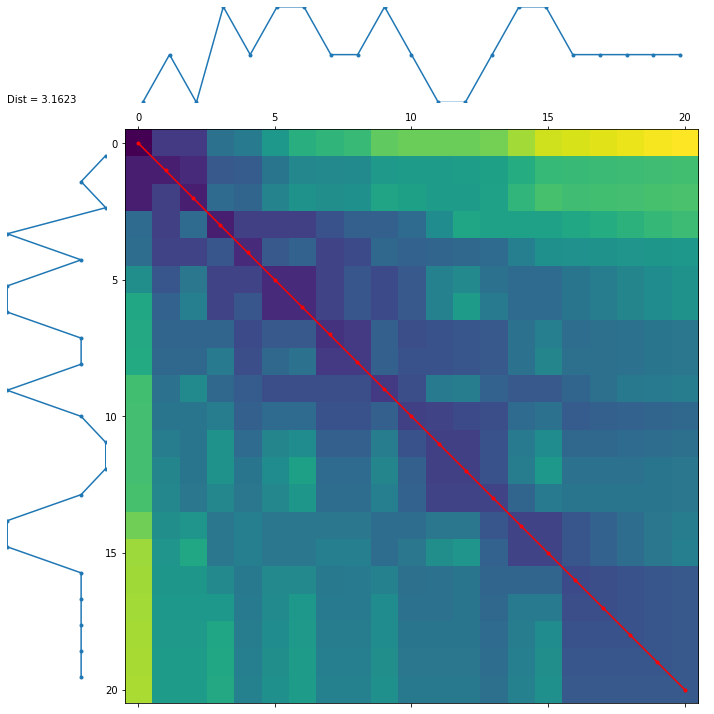

In [4]:
s1 = np.array([0,1,0,4,1,4,4,1,1,4,1,0,0,1,4,4,1,1,1,1,1], dtype=np.double)
s2 = np.array([0,2,0,4,2,4,4,2,2,4,2,0,0,2,4,4,2,2,2,2,2], dtype=np.double)
#path = dtw.warping_path(s1, s2)
#dtwvis.plot_warping(s1, s2, path, filename="warp.png")
#d = dtw.distance_fast(s1, s2)
#psi: number of start and end points of a sequence can be ignored if this would lead to a lower distance.
d, paths = dtw.warping_paths(s1, s2, window=25, psi=0) #, max_step=0
print(d)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path);

0.0


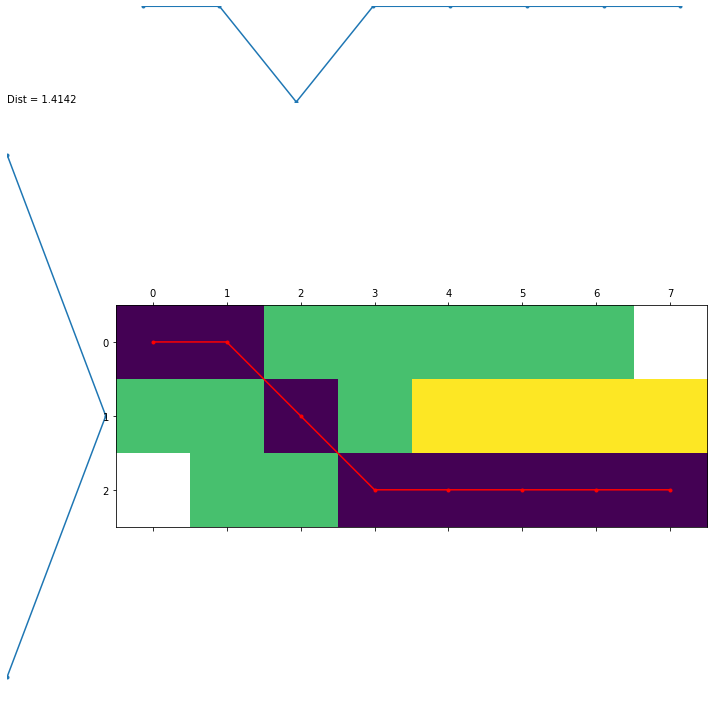

In [9]:
#s1 = np.array([0,1,0,4,1,4,4,1,1,4,1,0,0,1,4,4,1,1,1,1,1], dtype=np.double)
#s2 = np.array([0,0,1,4,2,4,4,2,2,4,2,0,0,2,4,4,2,2,2,2,2], dtype=np.double)
s1 = np.array([1,0,1], dtype=np.double)
s2 = np.array([1,1,0,1,1,1,1,1], dtype=np.double)
#path = dtw.warping_path(s1, s2)
#dtwvis.plot_warping(s1, s2, path, filename="warp.png")
#d = dtw.distance_fast(s1, s2)
#psi: number of start and end points of a sequence can be ignored if this would lead to a lower distance.
d, paths = dtw.warping_paths(s1, s2, window=2, psi=0) #, max_step=0
print(d)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path);

In [ ]:
series = np.matrix([
     [0., 0, 1, 2, 1, 0, 1, 0, 0],
     [0., 1, 2, 0, 0, 0, 0, 0, 0],
     [1., 2, 0, 0, 0, 0, 0, 1, 1],
     [0., 0, 1, 2, 1, 0, 1, 0, 0],
     [0., 1, 2, 0, 0, 0, 0, 0, 0],
     [1., 2, 0, 0, 0, 0, 0, 1, 1]])
#Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(series)
#Augment Hierarchical object to keep track of the full tree
model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(series)
#SciPy linkage clustering
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(series)
model2.plot("myplot2.png")
model3.plot("myplot3.png")


 
 
-------------------------------------------------------------------------------------------------


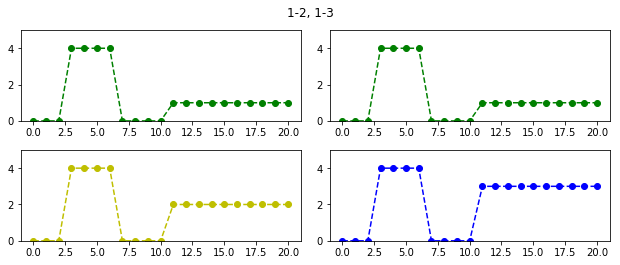

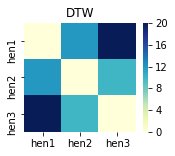

[[ 0. 12. 20.]
 [12.  0. 10.]
 [20. 10.  0.]]

 
 
-------------------------------------------------------------------------------------------------


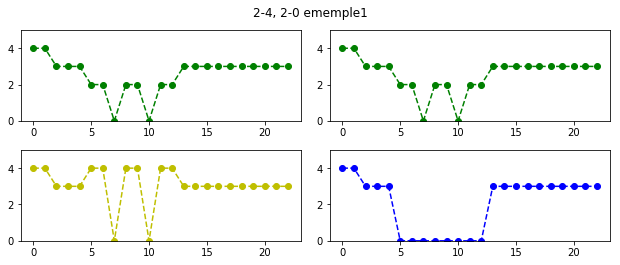

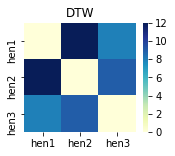

[[ 0. 12.  8.]
 [12.  0.  9.]
 [ 8.  9.  0.]]

 
 
-------------------------------------------------------------------------------------------------


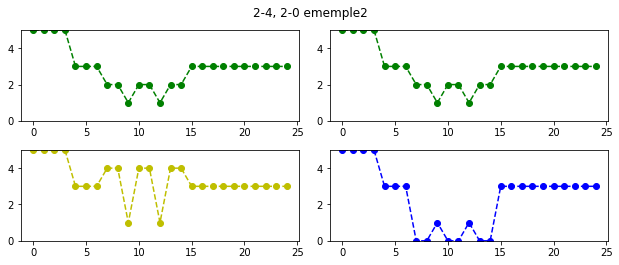

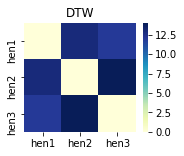

[[ 0. 13. 12.]
 [13.  0. 14.]
 [12. 14.  0.]]


In [19]:
#d = {'1':[1,2,3,4],'3':[1,1,1,1],'2':[2,2,2,2],'4':[2,2,2,1]} #test naming: working!
d1 = {'hen1':[0,1,0,4,1,4,4,1,1,4,1,0,0,1,4,4,1,1,1,1,1],
      'hen2':[0,2,0,4,2,4,4,2,2,4,2,0,0,2,4,4,2,2,2,2,2],
      'hen3':[0,3,0,4,3,4,4,3,3,4,3,0,0,3,4,4,3,3,3,3,3]}
d2 = {'hen1':[0,0,0,4,4,4,4,0,0,0,0,1,1,1,1,1,1,1,1,1,1],
      'hen2':[0,0,0,4,4,4,4,0,0,0,0,2,2,2,2,2,2,2,2,2,2],
      'hen3':[0,0,0,4,4,4,4,0,0,0,0,3,3,3,3,3,3,3,3,3,3]}
d3 = {'hen1':[4,4,3,3,3,2,2,0,2,2,0,2,2,3,3,3,3,3,3,3,3,3,3],
      'hen2':[4,4,3,3,3,4,4,0,4,4,0,4,4,3,3,3,3,3,3,3,3,3,3],
      'hen3':[4,4,3,3,3,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3]}
d4 = {'hen1':[5,5,5,5,3,3,3,2,2,1,2,2,1,2,2,3,3,3,3,3,3,3,3,3,3],
      'hen2':[5,5,5,5,3,3,3,4,4,1,4,4,1,4,4,3,3,3,3,3,3,3,3,3,3],
      'hen3':[5,5,5,5,3,3,3,0,0,1,0,0,1,0,0,3,3,3,3,3,3,3,3,3,3]}
d5 = {'hen1':[4,4,4,3,3,4,2,2,1,2,2,1,2,3,3,4,2,4,0,3,3],
      'hen2':[4,4,4,4,4,4,2,2,1,2,2,1,2,4,4,4,2,4,0,4,4], 
      'hen3':[4,4,4,2,2,4,2,2,1,2,2,1,2,2,2,4,2,4,0,2,2]} 

dico_title_d = {#'1-2, 1-3 exemple1':d1,
                '1-2, 1-3':d2,
                '2-4, 2-0 ememple1':d3,
                '2-4, 2-0 ememple2':d4}
                #'3-4, 3-2':d5}

for title,d in dico_title_d.items():
    
    print('\n \n \n-------------------------------------------------------------------------------------------------')
    #plot time series
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8.5,3.6))
    fig.suptitle(title) 
    axs[0,0].plot(d['hen1'], linestyle='--', marker='o', color='g')
    axs[0,0].set_ylim(0, 5)
    axs[0,1].plot(d['hen1'], linestyle='--', marker='o', color='g')
    axs[0,1].set_ylim(0, 5)
    #axs[0,1].set_title(str(d).split('T')[0], size=8)
    axs[1,0].plot(d['hen2'], linestyle='--', marker='o', color='y')
    axs[1,0].set_ylim(0, 5)
    axs[1,1].plot(d['hen3'], linestyle='--', marker='o', color='b')
    axs[1,1].set_ylim(0, 5)
    plt.show()
    
    #compute DTW and plot the resulting heatmap
    fig, ax = plt.subplots(figsize=(2.5,2)) 
    M,L = time_series_DTW(d) #e.g. L = {0: 'hen1', 1: 'hen2', 2: 'hen3'}
    L_sorted = [sorted(L.items(), key=lambda x: x[0])[i][1] for i in range(len(L))] #sort by keys (0) and take the values (1)
    sns.heatmap(M, xticklabels=L_sorted, yticklabels=L_sorted, cmap="YlGnBu")
    plt.title('DTW')
    plt.show()
    print(M)

In [14]:
#01234: OSWFN
#NNNNSSSS FSFSFSWw NNNN 
#44441111 31313122 4444
#NNNNSSSS WSWSWSFF NNNN
#44441111 21212133 4444

# DTW 3 random hens, inversing the order of two levels --> not same DTW


 
 
-------------------------------------------------------------------------------------------------


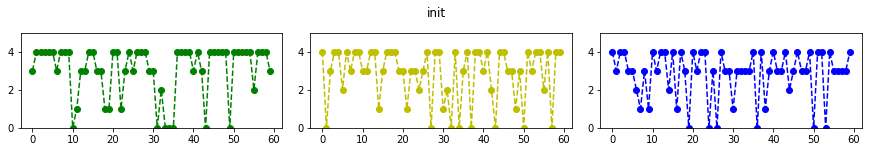

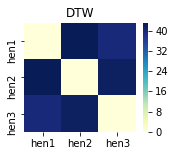

[[ 0. 43. 40.]
 [43.  0. 42.]
 [40. 42.  0.]]

 
 
-------------------------------------------------------------------------------------------------


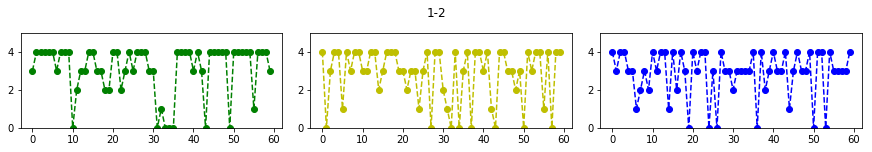

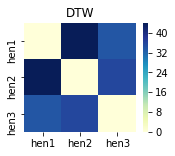

[[ 0. 44. 34.]
 [44.  0. 36.]
 [34. 36.  0.]]

 
 
-------------------------------------------------------------------------------------------------


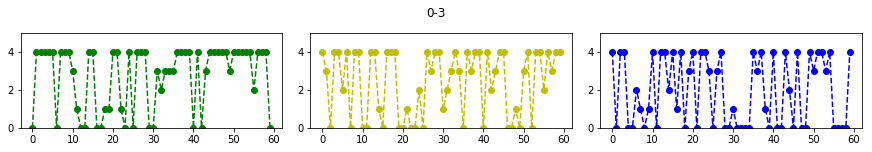

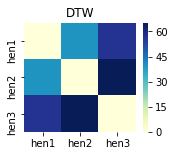

[[ 0. 40. 57.]
 [40.  0. 65.]
 [57. 65.  0.]]


In [43]:
population = [0,1,2,3,4] ; weights = [0.1, 0.05, 0.05, 0.2, 0.4]
li = random.choices(population, weights, k=100)
dico1 = {0:0,
        1:2,
        2:1,
        3:3,
        4:4}
dico2 = {0:3,
        1:1,
        2:2,
        3:0,
        4:4}
#fix mouvement of three hens
li1 = random.choices(population, weights, k=60)
li2 = random.choices(population, weights, k=60)
li3 = random.choices(population, weights, k=60)
d1 = {'hen1':li1, 'hen2':li2, 'hen3':li3}
#change order in barn of two levels
d2 = {'hen1': [dico1[i] for i in d1['hen1']],
      'hen2':[dico1[i] for i in d1['hen2']],
      'hen3':[dico1[i] for i in d1['hen3']]}
#change order in barn of two levels in a different way, but hen are still doing the exact same thing!
d3 = {'hen1': [dico2[i] for i in d1['hen1']],
      'hen2':[dico2[i] for i in d1['hen2']],
      'hen3':[dico2[i] for i in d1['hen3']]}
#display(d1)
#display(d2)
#display(d3)

dico_title_d = {#'1-2, 1-3 exemple1':d1,
                'init':d1,
                '1-2':d2,
                '0-3':d3}
                #'3-4, 3-2':d5}

for title,d in dico_title_d.items():
    
    print('\n \n \n-------------------------------------------------------------------------------------------------')
    #plot time series
    fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12,2))
    fig.suptitle(title) 
    axs[0].plot(d['hen1'], linestyle='--', marker='o', color='g')
    axs[0].set_ylim(0, 5)
    axs[1].plot(d['hen2'], linestyle='--', marker='o', color='y')
    axs[1].set_ylim(0, 5)
    axs[2].plot(d['hen3'], linestyle='--', marker='o', color='b')
    axs[2].set_ylim(0, 5)
    plt.show()
    
    #compute DTW and plot the resulting heatmap
    fig, ax = plt.subplots(figsize=(2.5,2)) 
    M,L = time_series_DTW(d) #e.g. L = {0: 'hen1', 1: 'hen2', 2: 'hen3'}
    L_sorted = [sorted(L.items(), key=lambda x: x[0])[i][1] for i in range(len(L))] #sort by keys (0) and take the values (1)
    sns.heatmap(M, xticklabels=L_sorted, yticklabels=L_sorted, cmap="YlGnBu")
    plt.title('DTW')
    plt.show()
    print(M)

# Sampent 3 random hens, inversing the order of two levels --> same SampEnt

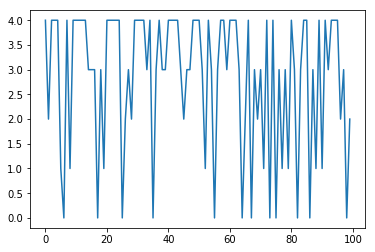

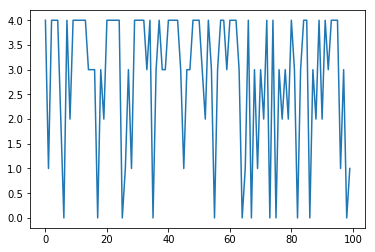

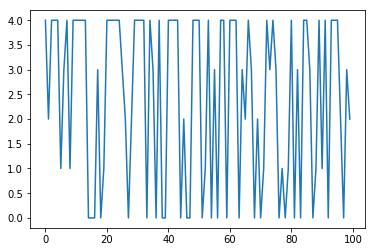

Sample Entropy:  1.0287426087076237 1.0287426087076237 1.0287426087076237


In [16]:
#ORDER DOES NOT COUNT WITH R=0!!!!!!!
population = [0,1,2,3,4] ; weights = [0.1, 0.05, 0.05, 0.2, 0.4]
li = random.choices(population, weights, k=100)
li[0:5]
li_hen1 = li
dico1 = {0:0,
        1:2,
        2:1,
        3:3,
        4:4}
li_hen2 = [dico1[i] for i in li_hen1]
dico2 = {0:3,
        1:1,
        2:2,
        3:0,
        4:4}
li_hen3 = [dico2[i] for i in li_hen1]
plt.plot(li_hen1)
plt.show()
plt.plot(li_hen2)
plt.show()
plt.plot(li_hen3)
plt.show()
print('Sample Entropy: ', sampen(li_hen1,0), sampen(li_hen2,0),  sampen(li_hen3,0))